### **Context**

The original video has 78,420 frames (40 min 34 s at 30 FPS).  
To reduce redundancy, we sampled 5,000 frames by selecting 1 every ~15.7 frames (0.5 s interval).  

In this notebook, for further analysis and visualization, we picked 1 frame every 500, resulting in a temporal resolution of 4 minutes and 10 seconds between comparisons.

Every operation can be applied to droplet masks generated with:
- **Opencv segmentation** -> _path = 'processed_data/droplet_masks'_
- **Trained U-Net model** -> _path = 'U-Net/droplet_unet'_


## Droplet Subtraction Over Time

To track droplet evolution, we subtract the mask at time _n+1_ from time _n_ and preserve only the differing pixels. This highlights regions where the droplet shape has changed by keeping only the non-overlapping areas.

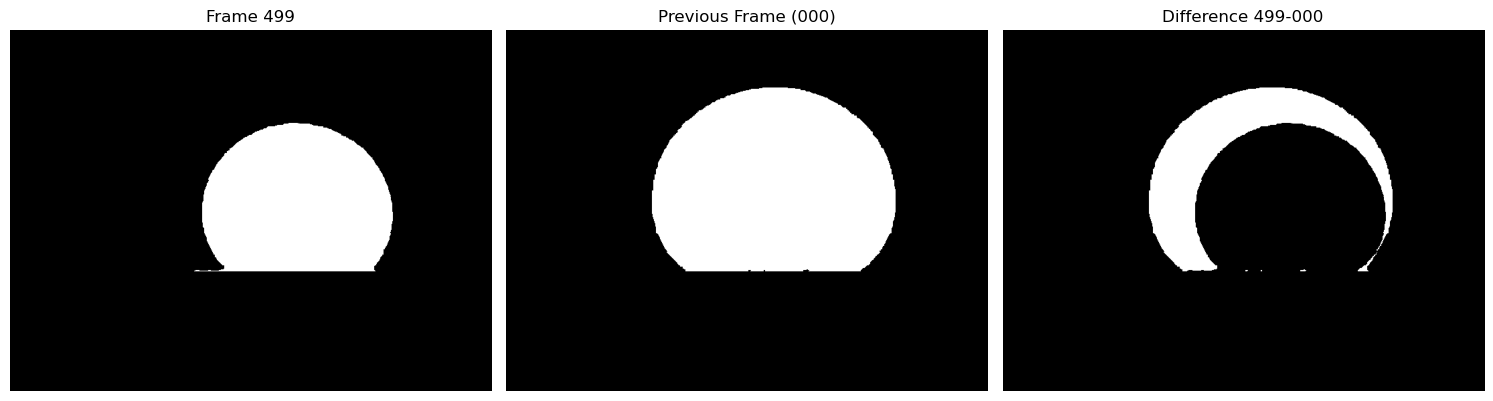

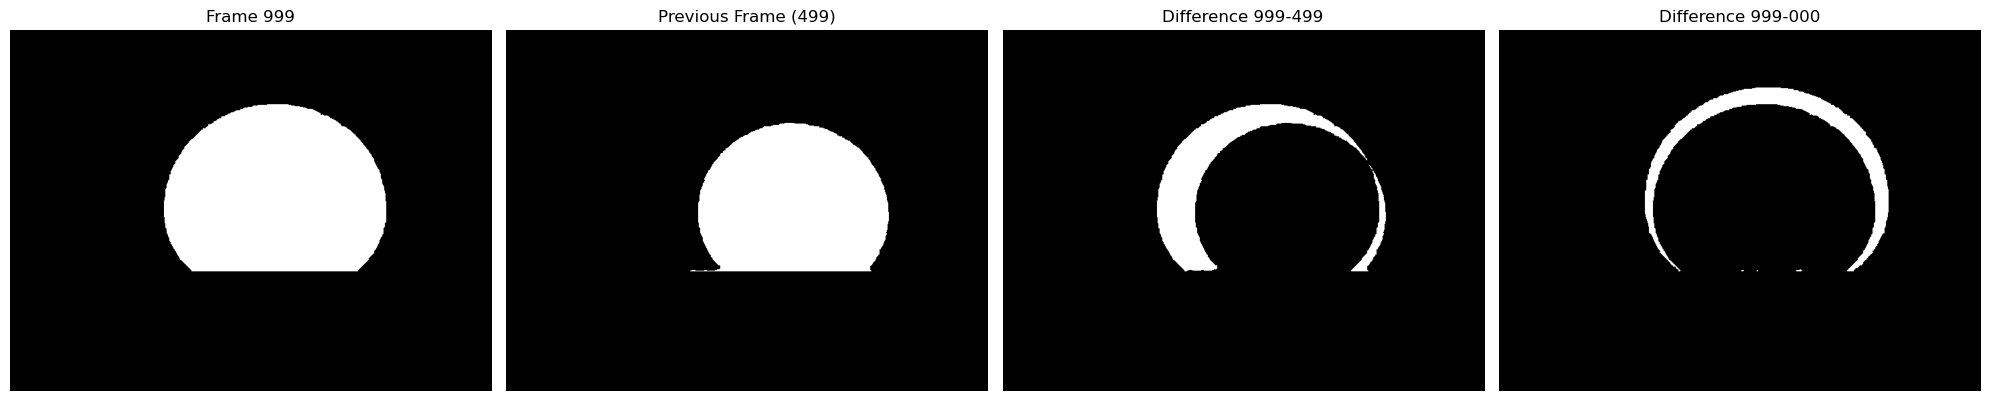

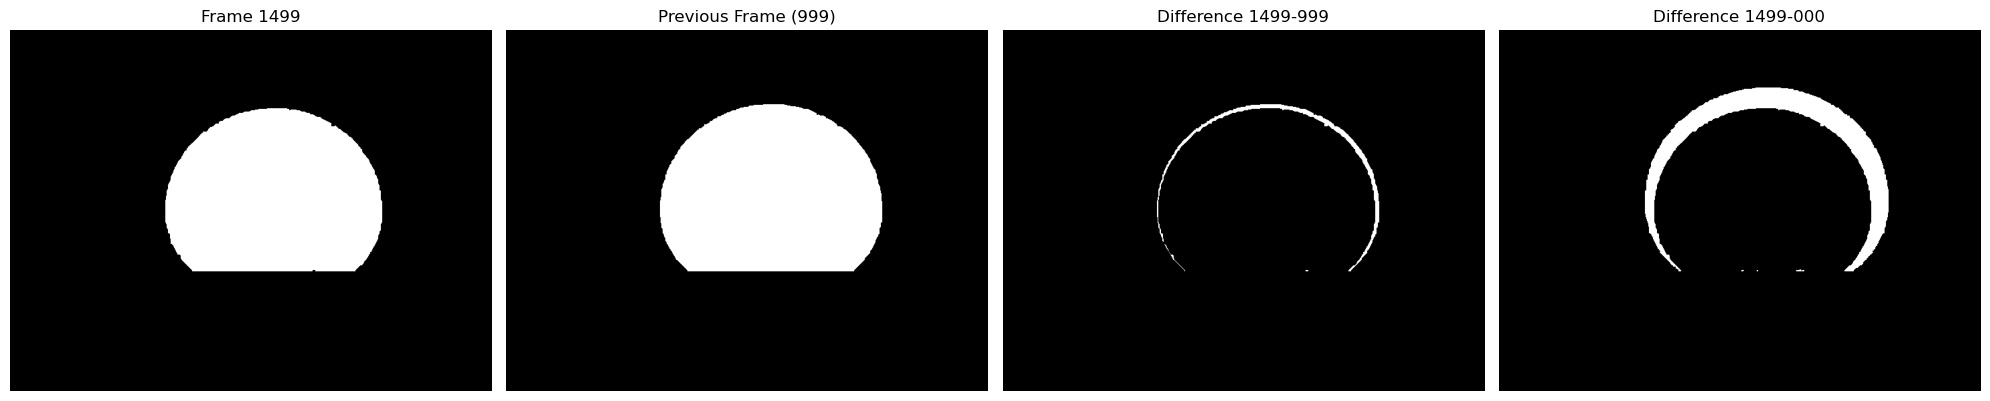

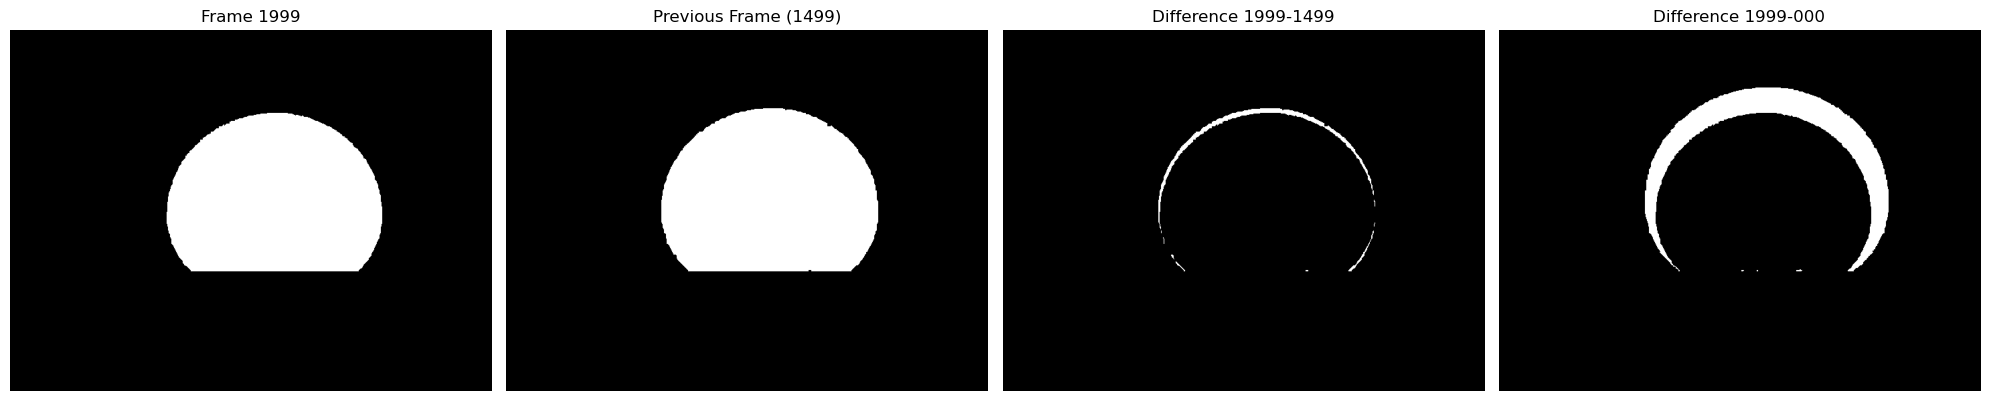

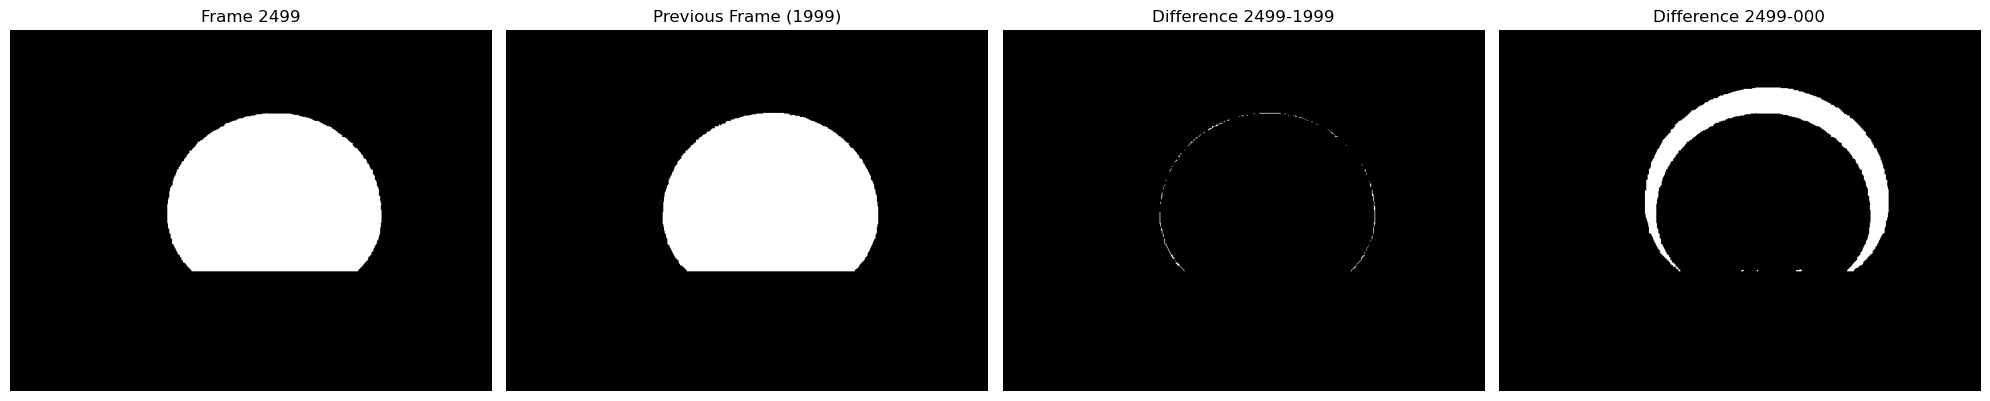

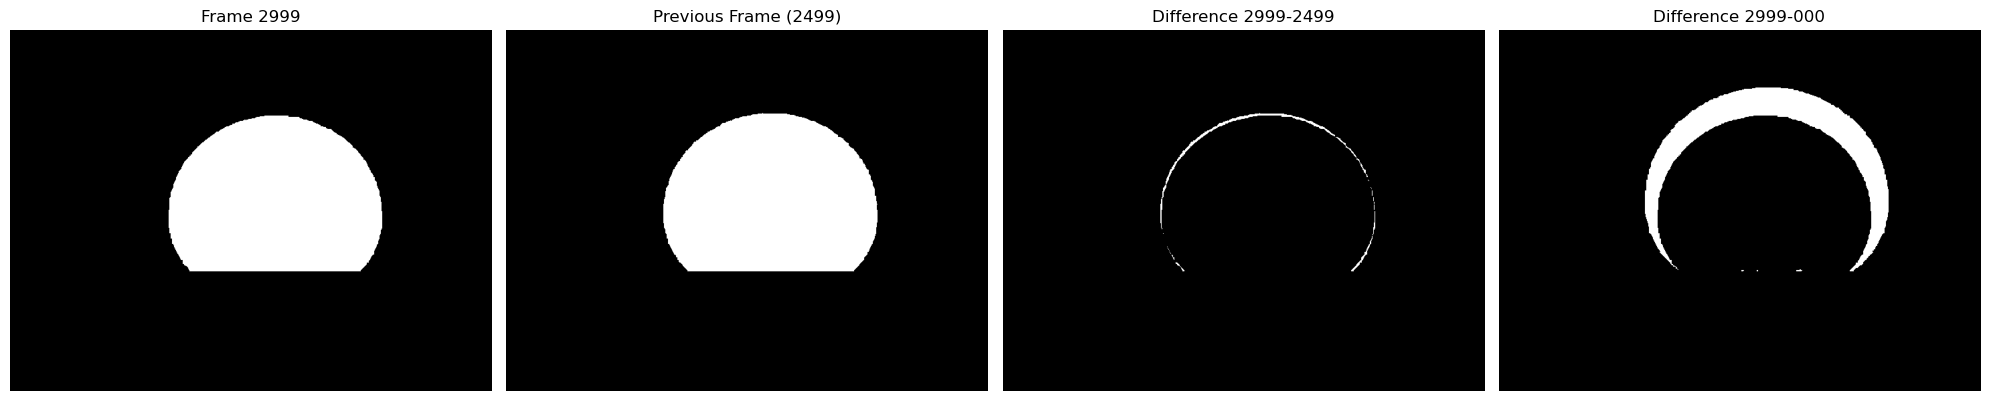

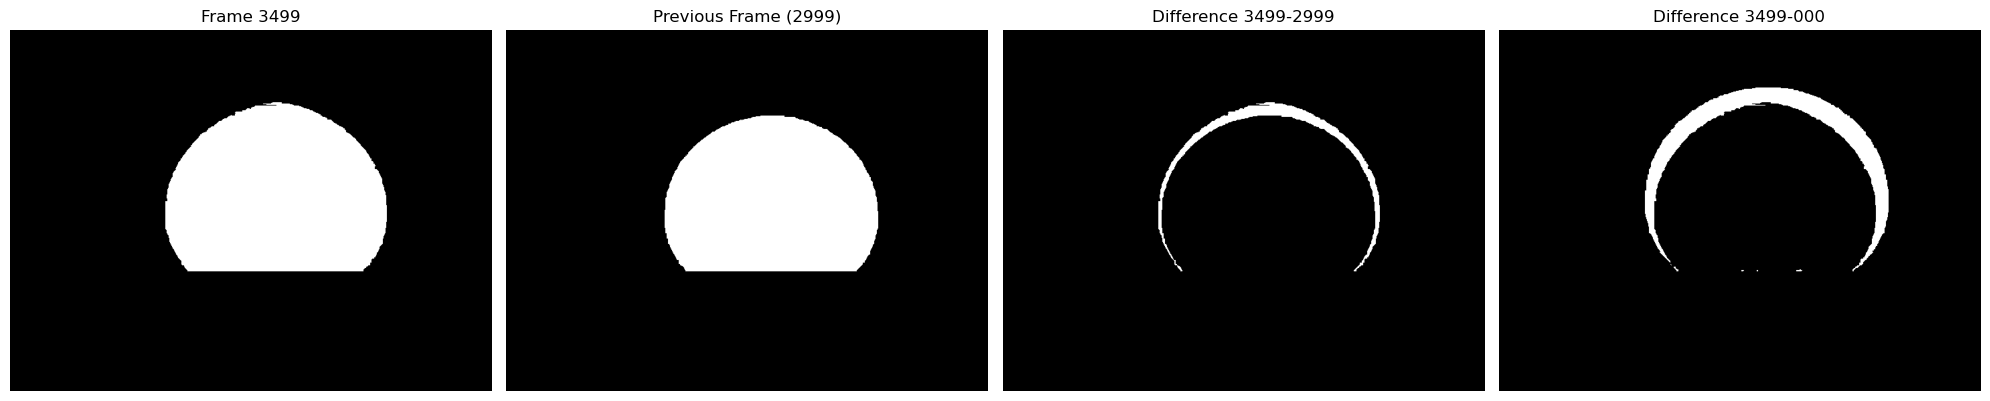

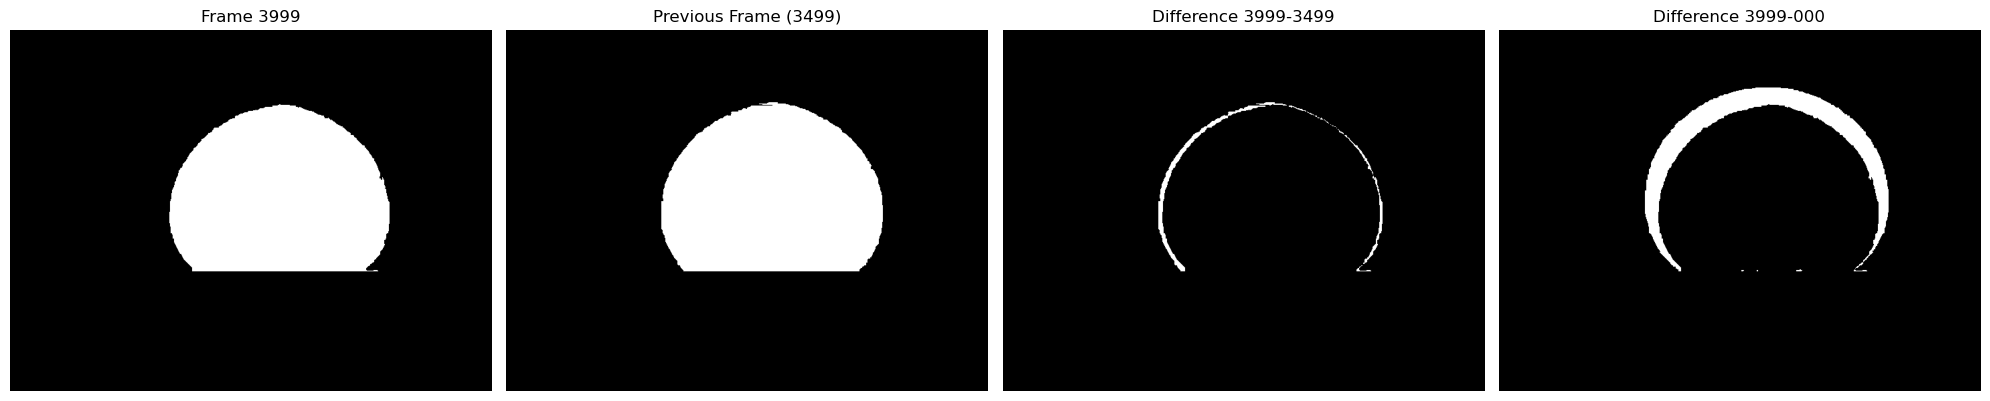

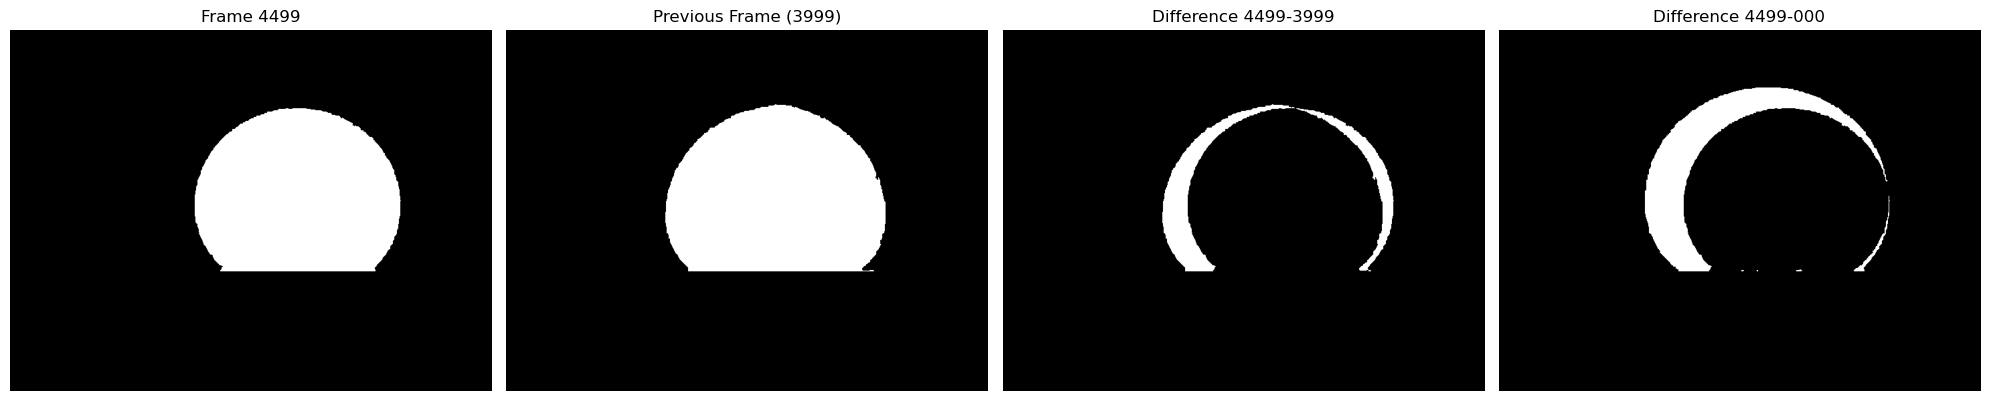

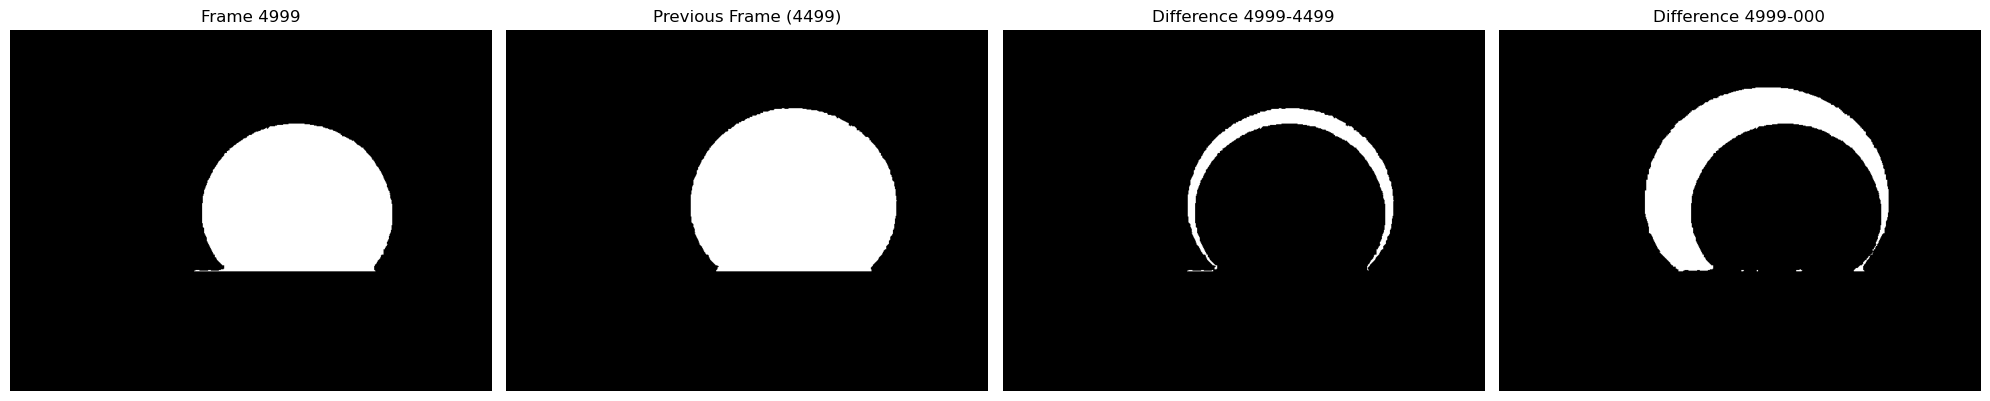

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# Droplet masks generated with opencv segmentation
path = 'processed_data/droplet_masks'

# Droplet masks generated with the trained U-Net model
# path = 'U-Net/droplet_unet'

def filename(index):
    pattern = os.path.join(path, f'frame_{index:03d}*.png')
    return glob.glob(pattern)[0]

# Load the first frame
first_frame = cv2.imread(filename(0), cv2.IMREAD_GRAYSCALE)

# Verify loading
if first_frame is None:
    raise ValueError("First image not loaded correctly. Check the file paths.")

# Previous frame starts as first frame
prev_frame = first_frame

# Frame indices: 0, 499, ..., 4999
indices = [0] + list(range(499, 5000, 500))

for idx in indices:
    # Skip the first frame
    if idx == 0: continue

    # Load current frame
    current_frame = cv2.imread(filename(idx), cv2.IMREAD_GRAYSCALE)
    
    if current_frame is None:
        print(f"Frame {idx} could not be loaded. Skipping...")
        continue

    # Calculate differences
    diff_prev = cv2.absdiff(current_frame, prev_frame)
    diff_first = cv2.absdiff(current_frame, first_frame)

    # Plotting
    plt.figure(figsize=(20, 5))

    # Current frame
    plt.subplot(1, 4, 1)
    plt.imshow(current_frame, cmap='gray')
    plt.title(f'Frame {idx:03d}')
    plt.axis('off')

    # Previous frame
    plt.subplot(1, 4, 2)
    plt.imshow(prev_frame, cmap='gray')
    plt.title(f'Previous Frame ({indices[indices.index(idx)-1]:03d})' if idx != 0 else 'N/A')
    plt.axis('off')

    # Difference with previous frame
    plt.subplot(1, 4, 3)
    plt.imshow(diff_prev, cmap='gray')
    plt.title(f'Difference {idx:03d}-{indices[indices.index(idx)-1]:03d}' if idx != 0 else 'N/A')
    plt.axis('off')

    # Difference with first frame (redundant for the second frame)
    if idx != 499:
        plt.subplot(1, 4, 4)
        plt.imshow(diff_first, cmap='gray')
        plt.title(f'Difference {idx:03d}-000')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Update previous frame
    prev_frame = current_frame


## Bounding Box Detection
In this section we detect the droplet bounding box from the droplet masks we precedently generated. 

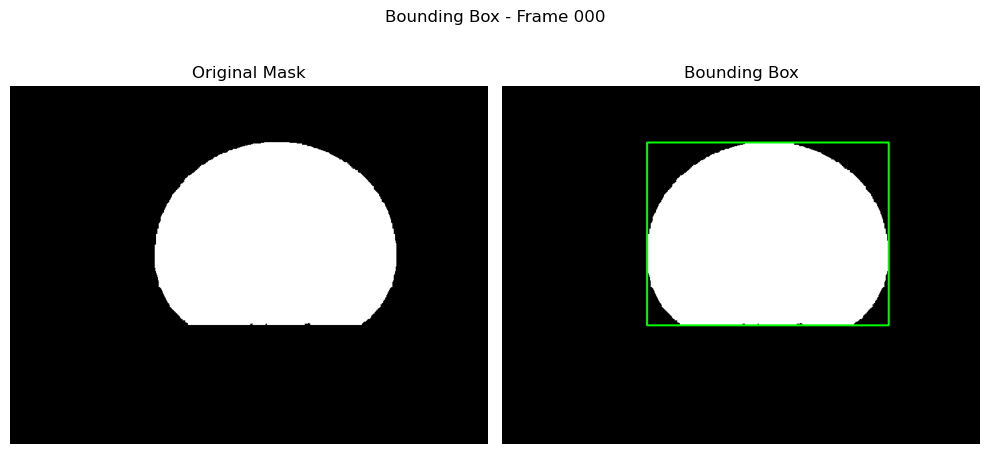

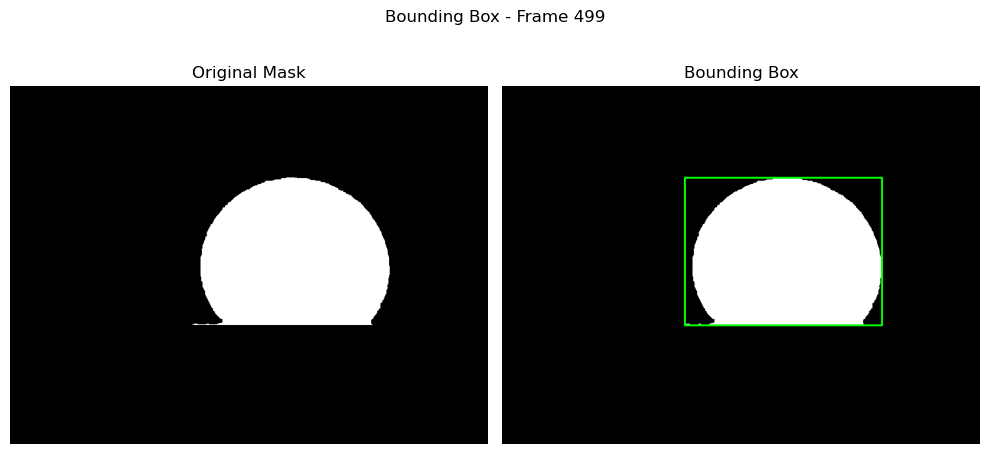

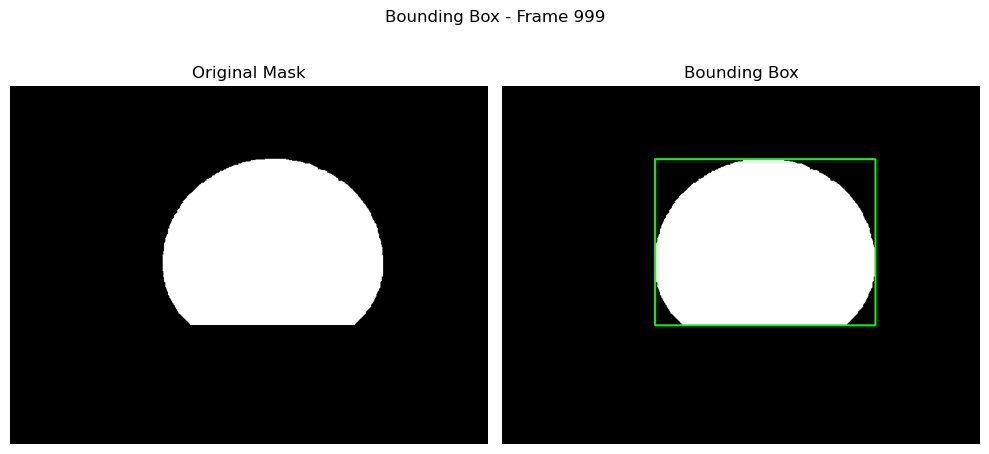

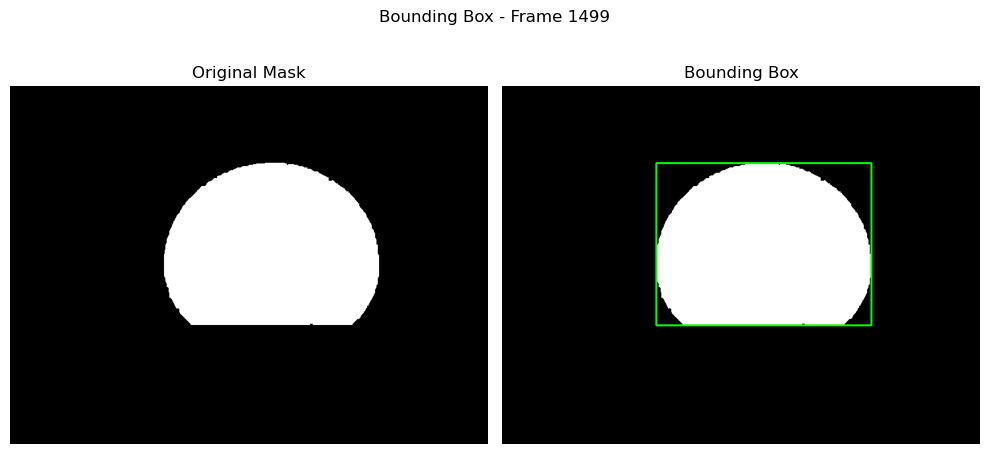

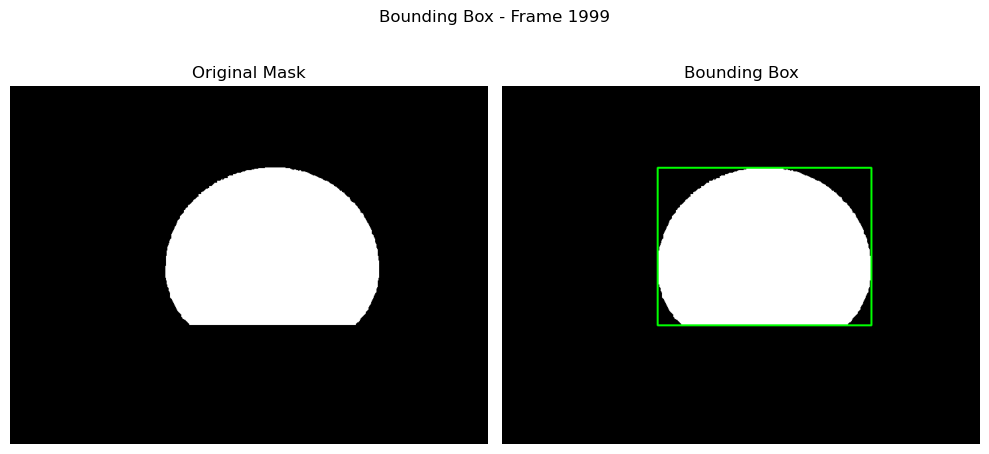

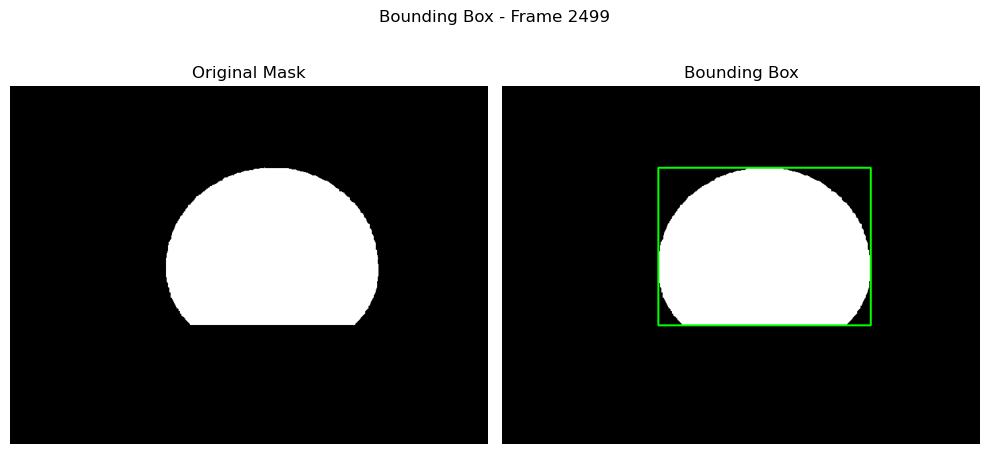

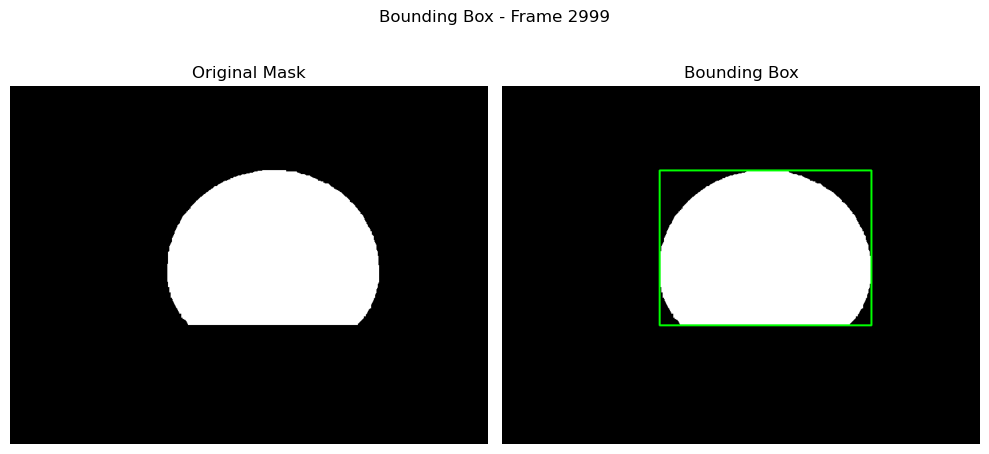

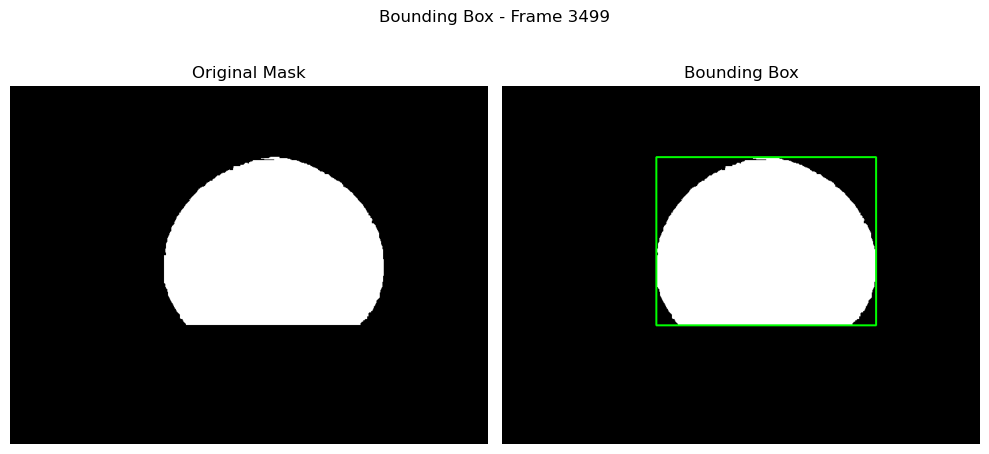

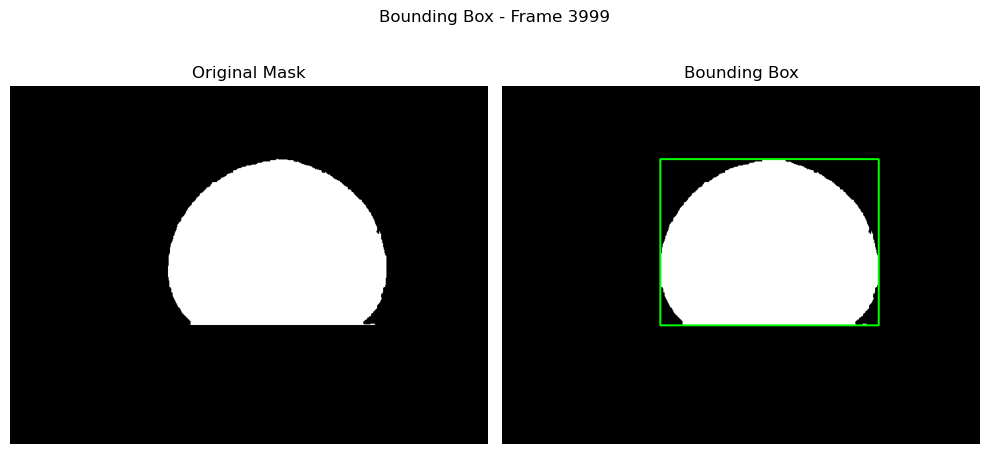

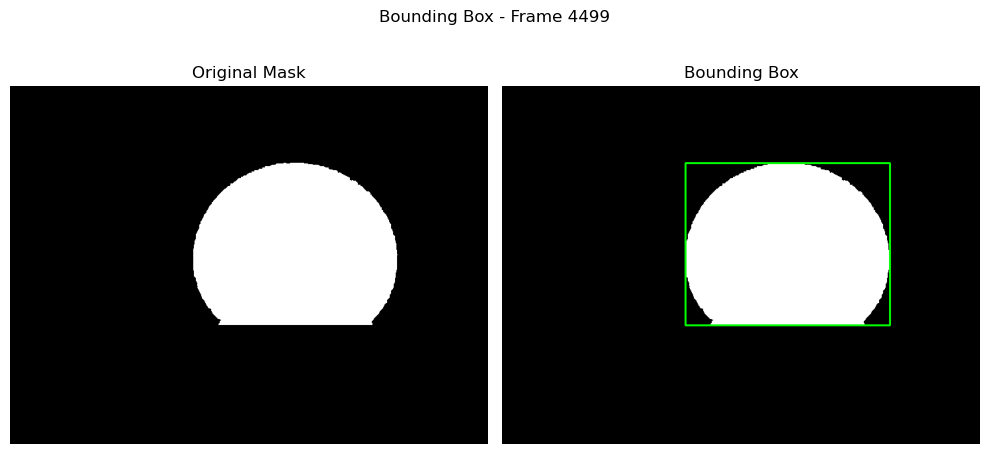

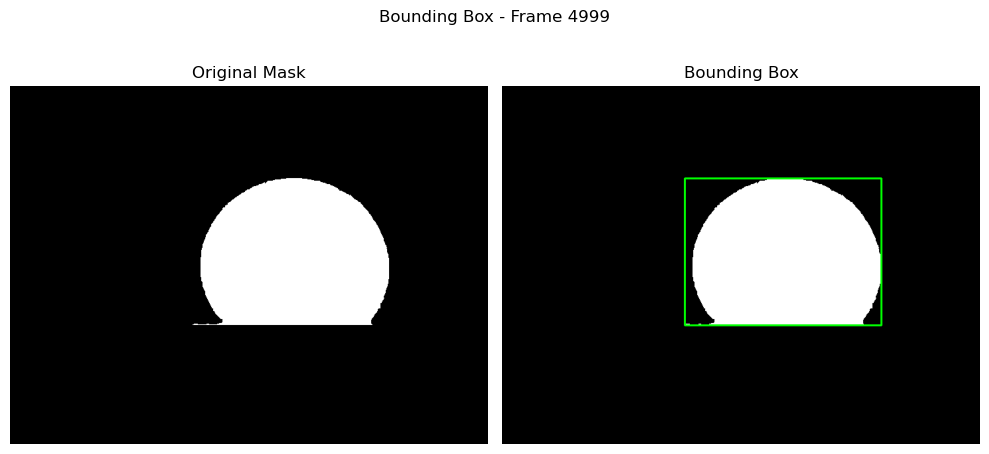

In [21]:
import cv2
import matplotlib.pyplot as plt
import os
import glob

# Droplet masks generated with opencv segmentation
path = 'processed_data/droplet_masks'

# Droplet masks generated with the trained U-Net model
#path = 'U-Net/droplet_unet'

def filename(index):
    pattern = os.path.join(path, f'frame_{index:03d}*.png')
    return glob.glob(pattern)[0]

# Process every 500 frames (e.g., 000, 499, 999, ...)
for i in range(0, 5001, 500):
    frame_idx = i if i == 0 else i - 1
    file = filename(frame_idx)
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Image {file} not found. Skipping...")
        continue

    # Threshold to binary
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print(f"No contours found in frame {frame_idx}.")
        continue

    # Get the largest contour and its bounding box
    contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(contour)

    # Draw bounding box
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(img_bgr, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.suptitle(f'Bounding Box - Frame {frame_idx:03d}')

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_bgr)
    plt.title('Bounding Box')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
